# Network Intrusion Detection with Deep Learning

In [0]:
import os


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## The Data

In [0]:
import numpy as np
def load_matrices(file_name):
    with open(file_name, 'rb') as f:
        A = np.load(f)
        B = np.load(f)
        C = np.load(f)
        D = np.load(f)
        E = np.load(f)
        F = np.load(f)
    return (A,B,C,D,E,F)

In [0]:
my_file =  '10data2.npy'
train,test,y_train,y_test,ylabel_train, ylabel_test = load_matrices(my_file)

## The Model

In [0]:
from keras import backend as K
from keras.layers import Input,Dense, Activation, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import InputLayer, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, CSVLogger

In [0]:
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

In [0]:

#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'


In [0]:
from keras.callbacks import ModelCheckpoint
filepath="./logtalos/best5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [0]:
from keras.models import Model, Sequential

In [0]:
# first we have to make sure to input data and params into the function
# add input parameters to the function
def dnn(x_train, ylabel_train, x_val, y_val, params):

    input_dim = x_train.shape[1]

    input_img = Input(shape=(input_dim,))
    
    first_neuron=params['first_neuron']
    second_neuron=params['second_neuron']
    third_neuron=params['third_neuron']
    batch_size=params['batch_size']
    kernel_initial=params['kernel_initializer']
    lr=params['lr']
    activation=params['activation']
    
    print('activation=',activation)
    
    log_file1 = './logtalos/best5/best5.hdf'
    checkpoint2 = ModelCheckpoint(log_file1, monitor='acc', save_best_only=True, mode='max')

    
    log_file2 = './logtalos/best5/best5.csv'

    csv_logger2 = CSVLogger(log_file2,separator=',', append=False)
    callbacks_list2 = [checkpoint2,csv_logger2]
    
    ###AE
    
    # replace the hyperparameter inputs with references to params dictionary 
    autoencoder = Sequential()
    #encoder
    
    if activation==PReLU: 
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(second_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(third_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
                   
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(second_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(first_neuron, kernel_initializer=kernel_initial))
        autoencoder.add(PReLU())
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
        
    else:
        autoencoder.add(Dense(first_neuron, input_shape=(input_dim,), activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(second_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(third_neuron, activation=activation, kernel_initializer=kernel_initial))
        #decoder
        #model.add(Dense(8, activation=params['activation']))
        autoencoder.add(Dense(second_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(first_neuron, activation=activation, kernel_initializer=kernel_initial))
        autoencoder.add(Dense(input_dim, activation='sigmoid', kernel_initializer=kernel_initial))
    
    #model = multi_gpu_model(model, gpus=1)
    autoencoder.summary()
    print(input_dim)
    
    input_img = Input(shape=(input_dim,))
    encoder_layer1 = autoencoder.layers[0]
    encoder_layer2 = autoencoder.layers[1]
    encoder_layer3 = autoencoder.layers[2]
    encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
    
    #encoder_layer1 = autoencoder.layers[0]
    #encoder_layer2 = autoencoder.layers[1]
    #encoder_layer3 = autoencoder.layers[2]
    #encoder = Model(input_img, encoder_layer3(encoder_layer2(encoder_layer1(input_img))))
    encoder.summary()

    
    autoencoder.compile(loss='mse', optimizer='adam', metrics=['acc'])
    #model.compile(loss=params['losses'],
    #              optimizer=params['optimizer'](),
    #              metrics=['acc', fmeasure_acc])
    
   

    
    history=autoencoder.fit(x,x,
                             epochs=params['epochs'],
                             batch_size=batch_size,
                              #shuffle=True,
                              #validation_split=0,
                              callbacks=callbacks_list,                    
                             #callbacks=[early_stopping])
                              validation_data=(test,test),
                              verbose=1)
  

    num_classes=15
    out2 = Dense(num_classes, activation='softmax',kernel_initializer=kernel_initial)(encoder.output)
    newmodel = Model(encoder.input,out2)
    
   
    newmodel.compile(loss='categorical_crossentropy', 
                     #optimizer='adam', 
                     optimizer= Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0, amsgrad=False),
                     metrics=['acc']) 
    newmodel.summary()


    history2a=newmodel.fit(x, y,
                           epochs=params['epochs2'],
                           batch_size=batch_size,
                           #validation_split=0,
                           callbacks=callbacks_list2,
                           #callbacks=[early_stopping],
                           validation_data=(test,ylabel_test),
                           verbose=1)

    
    del encoder
    del autoencoder
    #del dnn_model
    
    tf.reset_default_graph()
    
    return history2a, newmodel #, encoder
    

In [0]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[60],
     'second_neuron':[30],
     'third_neuron':[25],   
     'batch_size': [256],
     'epochs': [20],
     'epochs2': [200],
     'dropout': [0],
     'kernel_initializer': ['he_normal'],
     'optimizer': [Adam],
     'lr':[0.001],
     'activation':[relu]}

In [0]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, clear_session

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True#True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [0]:
x=train
y=ylabel_train

In [56]:
np.shape(x)

(1619315, 80)

In [57]:
np.shape(y)

(1619315, 15)

In [58]:

t = ta.Scan(x, y, p, dnn, experiment_no='5')#,grid_downsample=0.05,)



  0%|          | 0/1 [00:00<?, ?it/s]

activation= <function relu at 0x7f3f916fe730>
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                775       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                780       
_________________________________________________________________
dense_12 (Dense)             (None, 60)                1860      
_________________________________________________________________
dense_13 (Dense)             (None, 80)                4880      
Total params: 14,985
Trainable params: 14,985
Non-trainable params: 0
____


100%|██████████| 1/1 [1:19:56<00:00, 4796.77s/it]


Scan Finished!


In [59]:
x.shape

(1619315, 80)

In [60]:
t.data

,round_epochs,val_loss,val_acc,loss,acc,first_neuron,second_neuron,third_neuron,batch_size,epochs,epochs2,dropout,kernel_initializer,optimizer,lr,activation
1,200,0.11999300242409687,0.9578742997187841,0.12050415424059185,0.9573696285150988,60,30,25,256,20,200,0,he_normal,<class 'keras.optimizers.Adam'>,0.001,<function relu at 0x7f3f916fe730>


In [0]:
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import PReLU
#actvation leakyrelu
LR= LeakyReLU(0.01)
LR.__name__ = 'lrelu'
#actvation prelu
PR= PReLU()
PR.__name__ = 'prelu'

In [67]:
## load model 
filepath2='./logtalos/best5/best5.hdf'
dnn=load_model(filepath2)
##karena fungsi aktivasi relu bisa diload
dnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 80)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_10 (Dense)             (None, 25)                775       
_________________________________________________________________
dense_14 (Dense)             (None, 15)                390       
Total params: 7,855
Trainable params: 7,855
Non-trainable params: 0
_________________________________________________________________


In [68]:
##loading autoencoder untuk data tes
# load weights
dnn.load_weights(filepath2)
# Compile model (required to make predictions)
dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")
scores = dnn.evaluate(test, ylabel_test, verbose=0)
print("%s: %.2f%%" % (dnn.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
acc: 95.78%


In [69]:
result_train = dnn.evaluate(train,ylabel_train)
for name, value in zip(dnn.metrics_names, result_train):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_train[1]*100))

1619315/1619315 [==============================] - 31s 19us/step
loss 0.12003683476555393
acc 0.9575789762955692
acc: 95.76%


In [0]:
##prediksi data Train

preds = dnn.predict(train)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_train, axis=1)

In [0]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
from sklearn.metrics import classification_report
outcomes = ['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS',
'DDOS attack-HOIC','DDOS attack-LOIC-UDP','DDoS attacks-LOIC-HTTP',
'DoS attacks-GoldenEye','DoS attacks-Hulk','DoS attacks-SlowHTTPTest','DoS attacks-Slowloris',
'FTP-BruteForce','Infilteration','SQL Injection','SSH-Bruteforce' ]
class_names=outcomes


target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

                          precision    recall  f1-score   support

                  Benign    0.95539   0.99510   0.97484    803025
                     Bot    0.99987   0.99981   0.99984     85842
        Brute Force -Web    0.75699   0.70968   0.73257       496
        Brute Force -XSS    1.00000   0.48663   0.65468       187
        DDOS attack-HOIC    1.00000   1.00000   1.00000    192098
    DDOS attack-LOIC-UDP    0.90696   0.96623   0.93566      1362
  DDoS attacks-LOIC-HTTP    0.99912   0.99903   0.99908    161447
   DoS attacks-GoldenEye    0.99836   0.99968   0.99902     25008
        DoS attacks-Hulk    0.99990   0.99978   0.99984    138459
DoS attacks-SlowHTTPTest    0.77069   0.50565   0.61065     41974
   DoS attacks-Slowloris    0.99548   1.00000   0.99774      6612
          FTP-BruteForce    0.71367   0.89128   0.79264     58055
           Infilteration    0.74625   0.23164   0.35354     48347
           SQL Injection    0.84615   0.46479   0.60000        71
         

Confusion matrix, without normalization
[[799090     11      5      0      0      0     62      7      4      1
      28      2   3807      3      5]
 [    16  85826      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [   122      0    352      0      0      0     20      0      0      0
       0      0      0      2      0]
 [     7      0     78     91      0      0     11      0      0      0
       0      0      0      0      0]
 [     0      0      0      0 192098      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0   1316     46      0      0      0
       0      0      0      0      0]
 [    21      0      0      0      0    135 161291      0      0      0
       0      0      0      0      0]
 [     1      0      0      0      0      0      0  25000      6      0
       1      0      0      0      0]
 [     0      0      0      0      0      0      0     31 138428      0
       0

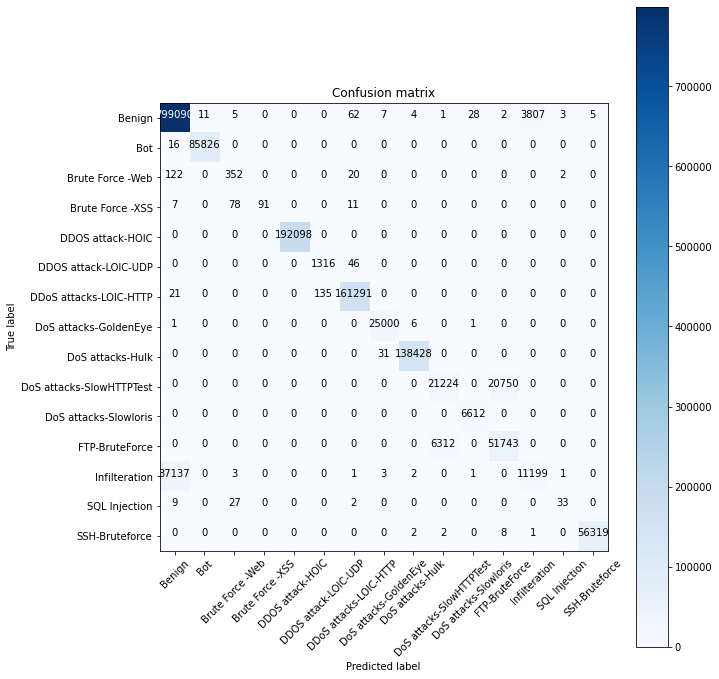

In [73]:
#outcomes = ['DoS', 'normal','Probe' ,'R2L', 'U2R']
class_names=outcomes


results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))

# Data Test

In [74]:
#Data Test
result_test = dnn.evaluate(test,ylabel_test)
for name, value in zip(dnn.metrics_names, result_test):
    print(name, value)
    
print("%s: %.2f%%" % (dnn.metrics_names[1], result_test[1]*100))

404836/404836 [==============================] - 7s 18us/step
loss 0.12026550560202744
acc 0.9578150164511061
acc: 95.78%


In [0]:
##prediksi data Train
#y_test=y_test.to_numpy()

preds = dnn.predict(test)
pred_lbls = np.argmax(preds, axis=1)
true_lbls = np.argmax(ylabel_test, axis=1)

                          precision    recall  f1-score   support

                  Benign    0.95622   0.99472   0.97509    201238
                     Bot    0.99986   0.99967   0.99977     21479
        Brute Force -Web    0.69369   0.66957   0.68142       115
        Brute Force -XSS    0.95455   0.48837   0.64615        43
        DDOS attack-HOIC    1.00000   1.00000   1.00000     48006
    DDOS attack-LOIC-UDP    0.87750   0.95380   0.91406       368
  DDoS attacks-LOIC-HTTP    0.99905   0.99853   0.99879     40219
   DoS attacks-GoldenEye    0.99804   0.99935   0.99869      6123
        DoS attacks-Hulk    0.99983   0.99971   0.99977     34758
DoS attacks-SlowHTTPTest    0.77010   0.50992   0.61357     10484
   DoS attacks-Slowloris    0.99088   1.00000   0.99542      1630
          FTP-BruteForce    0.71445   0.88970   0.79251     14452
           Infilteration    0.73203   0.23385   0.35447     11892
           SQL Injection    0.85714   0.37500   0.52174        16
         

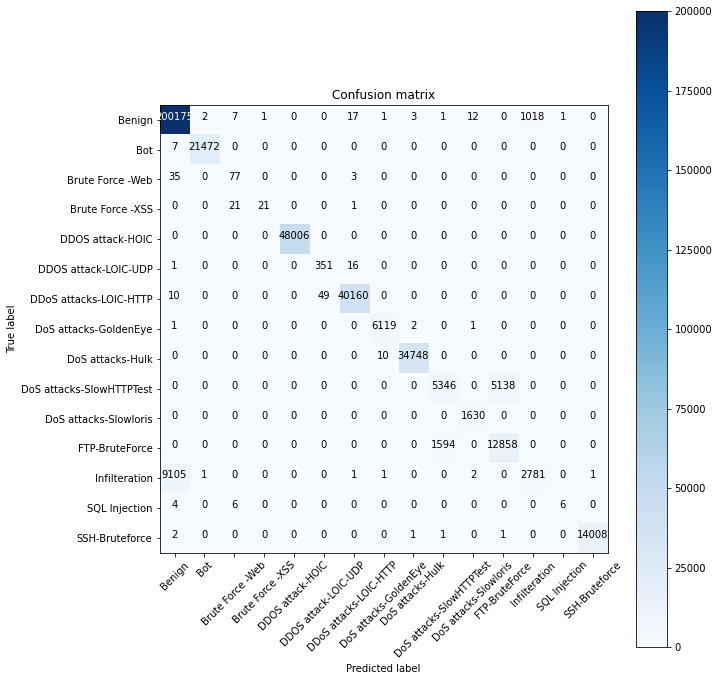

In [76]:
target_names = ["Class {}".format(i) for i in range(15)]
print(classification_report(true_lbls, pred_lbls, target_names=class_names, digits=5))
#print(classification_report(Y_test, y_predict))

results = confusion_matrix(true_lbls, pred_lbls)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(results, classes=class_names,
                      title='Confusion matrix')

#print(classification_report(y_test, deepprediction, target_names=class_names, digits=5))